### Import

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

### Data Load

In [12]:
train = pd.read_csv('./train.csv').drop(columns=['ID'])
test = pd.read_csv('./test.csv').drop(columns=['ID'])

### 0. 확정 전처리 

In [14]:
df= train

# '시술 당시 나이' 변수 수치형 변환
age_mapping = {
    '만18-34세': 1, '만35-37세': 2, '만38-39세': 3, '만40-42세': 4,
    '만43-44세': 5, '만45-50세': 6, '알 수 없음': 7
}
df['시술 당시 나이'] = df['시술 당시 나이'].map(age_mapping)

# '~횟수' 변수 수치형 변환
count_features = [feat for feat in df.columns if '횟수' in feat]
for feat in count_features:
    df[feat] = df[feat].apply(lambda val: int(val[0]))  # n회/n회 이상 (str) -> n (int)

# '정자, 난자 기증자 나이' 변수 수치형 변환
for feat in ['난자 기증자 나이', '정자 기증자 나이']:
    df[feat] = df[feat].apply(lambda val: int(val[1:3]) if val[0] == '만' else -1)

# 배아 생성 주요 이유 다중 선택 변환 (더미 컬럼 생성)
categories = ['현재 시술용', '배아 저장용', '기증용', '난자 저장용']
for category in categories:
    df[f'배아 이유_{category}'] = df['배아 생성 주요 이유'].apply(lambda x: 1 if pd.notna(x) and category in x else 0)

# '출산 성공률' 파생변수 생성
df['출산 성공률'] = df['총 출산 횟수'] / df['총 임신 횟수']

# '임신 성공률' 파생변수 생성
df['임신 성공률'] = df['총 임신 횟수'] / df['총 시술 횟수']

# IVF / DI 개별 전처리
ivf_df = df[df['시술 유형'] == 'IVF'].copy()
di_df = df[df['시술 유형'] == 'DI'].copy()

# DI인 경우 남성 주 ~ 부부 부 불임 원인 flip
flip_features = ['남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인',
                 '여성 부 불임 원인', '부부 주 불임 원인', '부부 부 불임 원인', '불임 원인 - 정자 농도']
for feat in flip_features:
    di_df[feat] = di_df[feat].apply(lambda x: 1 - x)

# 확정 결측치 처리
missing_fill_features = ['PGS 시술 여부', 'PGD 시술 여부', '착상 전 유전 검사 사용 여부']
for feat in missing_fill_features:
    ivf_df[feat] = ivf_df[feat].fillna(0)

# IVF와 DI 데이터 다시 결합
df[df['시술 유형'] == 'IVF'] = ivf_df
df[df['시술 유형'] == 'DI'] = di_df

### 1. 시술 이전 정보 컬럼 선택 

In [15]:
# 시술 이전 정보 칼럼만 선택
features = [
    '시술 당시 나이', 
    '임신 시도 또는 마지막 임신 경과 연수',
    '남성 주 불임 원인', 
    '남성 부 불임 원인', 
    '여성 주 불임 원인',
    '여성 부 불임 원인', 
    '부부 주 불임 원인', 
    '부부 부 불임 원인', 
    '불명확 불임 원인',
    '불임 원인 - 난관 질환', 
    '불임 원인 - 남성 요인', 
    '불임 원인 - 배란 장애', 
    '불임 원인 - 여성 요인',
    '불임 원인 - 자궁경부 문제', 
    '불임 원인 - 자궁내막증', 
    '불임 원인 - 정자 농도', 
    '불임 원인 - 정자 면역학적 요인',
    '불임 원인 - 정자 운동성', 
    '불임 원인 - 정자 형태',  
    '총 시술 횟수',
    '클리닉 내 총 시술 횟수',
    'IVF 시술 횟수',
    'DI 시술 횟수',
    '총 임신 횟수',
    'IVF 임신 횟수',
    'DI 임신 횟수',
    '총 출산 횟수',
    'IVF 출산 횟수',
    'DI 출산 횟수'
]

df_clustering = df[features].copy()


### 2. 결측치 처리 

In [16]:
df_clustering= df_clustering.fillna(-1)

'임신 시도 또는 마지막 임신 경과 연수'에서 나는 결측치 

### 3. 최적 k 값 찾기 - 실루엣 계수 

In [17]:
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for n_clusters in tqdm(range(2, 8)): 
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_clustering)

    score = silhouette_score(df_clustering, cluster_labels)
    print(f"클러스터 수: {n_clusters}, 실루엣 계수: {score:.4f}")

 17%|█▋        | 1/6 [13:37<1:08:05, 817.17s/it]

클러스터 수: 2, 실루엣 계수: 0.4709


 33%|███▎      | 2/6 [26:56<53:47, 806.78s/it]  

클러스터 수: 3, 실루엣 계수: 0.4311


 50%|█████     | 3/6 [38:59<38:24, 768.32s/it]

클러스터 수: 4, 실루엣 계수: 0.3299


 67%|██████▋   | 4/6 [50:00<24:12, 726.01s/it]

클러스터 수: 5, 실루엣 계수: 0.2945


 83%|████████▎ | 5/6 [1:05:20<13:15, 795.97s/it]

클러스터 수: 6, 실루엣 계수: 0.2911


100%|██████████| 6/6 [1:15:31<00:00, 755.20s/it]

클러스터 수: 7, 실루엣 계수: 0.2662


- 실루엣 계수 : 1에 가까울 수록 근처 군집과 멀리 떨어져 있음을, 0에 가까울수록 근처 군집과 가까움 ~ 보통 0.5 이상을 잘 분리됐다고 판단 
- 제일 높은 게 클러스터 2개 - 0.4709 


### 4. 실루엣 계수 시각화 

In [ ]:
def plot_silhouette_comparison(X, k_range=(2, 7)):
    fig, axes = plt.subplots(1, k_range[1] - k_range[0] + 1, figsize=(22, 5))

    for idx, n_clusters in enumerate(range(k_range[0], k_range[1] + 1)):
        ax = axes[idx] if isinstance(axes, np.ndarray) else axes
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                             0, ith_cluster_silhouette_values,
                             facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax.set_title(f"Clusters: {n_clusters}\nSilhouette: {silhouette_avg:.3f}")
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        ax.set_yticks([])
        ax.set_xlabel("Silhouette Coefficient")

    plt.tight_layout()
    plt.show()


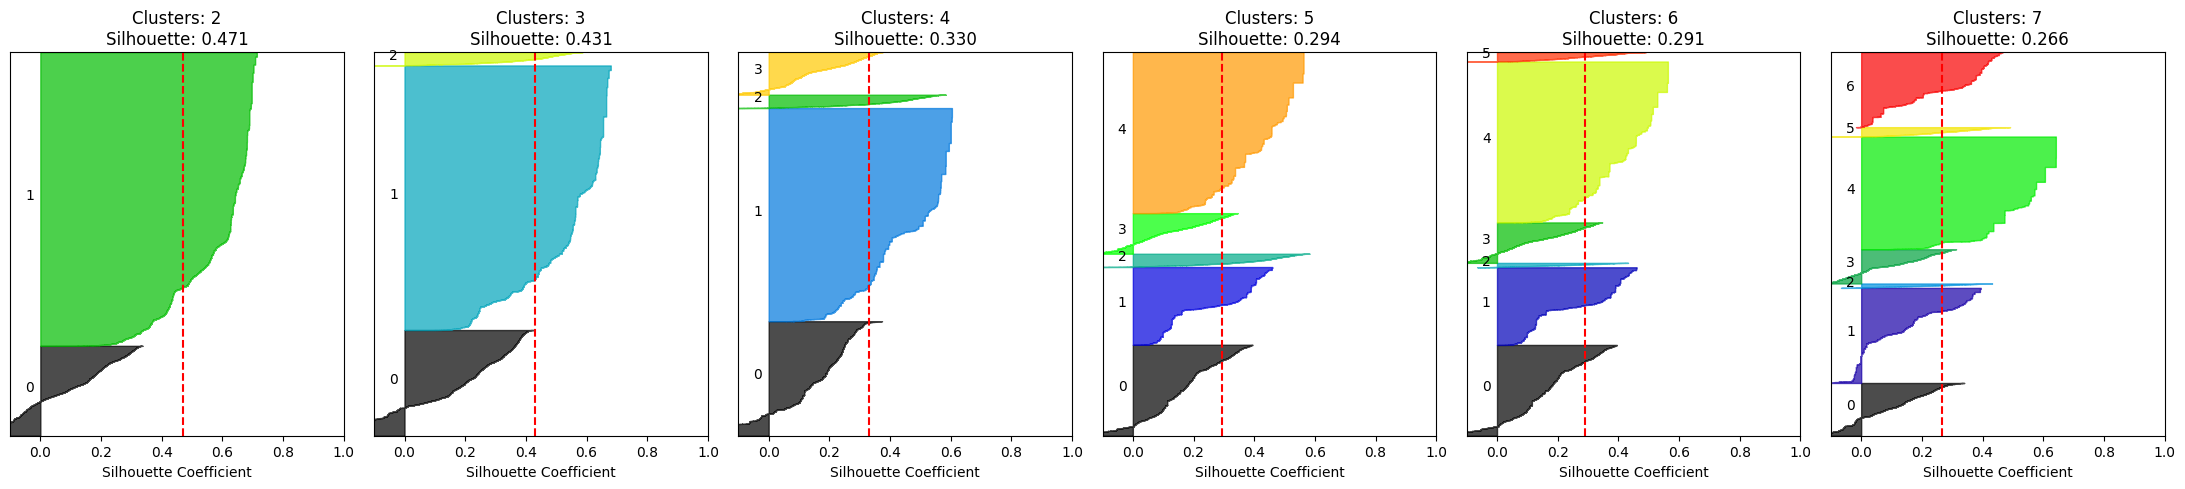

In [19]:
plot_silhouette_comparison(df_clustering, k_range=(2, 7))

### 5. 클러스터링 진행 

일단 k = 2로 진행해봄..

In [ ]:
# 최종 클러스터링 진행
best_k = 2 # 최적의 k 값 
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(df_clustering)

# 결과를 원본 데이터프레임에 붙이기
df_clustering["cluster"] = cluster_labels


In [ ]:
df_clustering['cluster'].value_counts().sort_index()

cluster
0     60067
1    196284
Name: count, dtype: int64

In [ ]:
df_clustering.groupby("cluster").mean().T

cluster,0,1
시술 당시 나이,2.781511,2.155897
임신 시도 또는 마지막 임신 경과 연수,0.547206,-0.983188
남성 주 불임 원인,0.156758,0.018407
남성 부 불임 원인,0.099056,0.017602
여성 주 불임 원인,0.160438,0.018942
여성 부 불임 원인,0.097841,0.017021
부부 주 불임 원인,0.171459,0.019029
부부 부 불임 원인,0.084522,0.016960
불명확 불임 원인,0.226014,0.258294
불임 원인 - 난관 질환,0.137213,0.139161
